# Dog Breed Classification
## Using Transfer Learning to predict the breed of a dog based on images

In this project, I will be using deep learning techniques to build a multi-class classification model to identify different breeds of dogs from their images.

### Import Libraries

In [2]:
# Utilties
import os
import datetime

# Data processing
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Viewing images
from IPython.display import display, Image

# Machine Learning packages
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

%load_ext tensorboard

### Retrieving Data and EDA

The images are provided as two folders of images already split into train and test sets. For the training set we are given a .csv file mapping the image id to its true label. For test, we can only make predictions and use the Kaggle interface to evaluate how well the model is performing.

In [3]:
# define filepaths to simplify access

filepath = "/home/mattzirp/Documents/Metis/deep_learning/project_data/"
labels_path = filepath + "labels.csv"
train_path = filepath + "train/"
test_path = filepath +"test/"

In [4]:
labels = pd.read_csv(labels_path)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


So we've got 120 different breeds in the dataset, let's see how they're distributed

In [9]:
labels["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

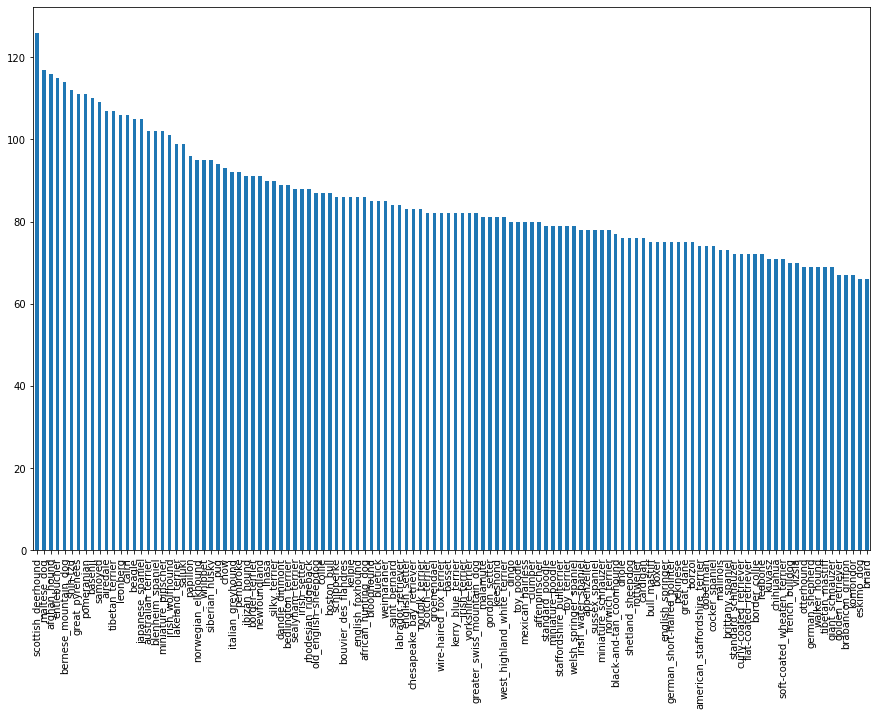

In [129]:
labels["breed"].value_counts().plot.bar(figsize=(15, 10));

In [7]:
labels["breed"].value_counts().mean()

85.18333333333334

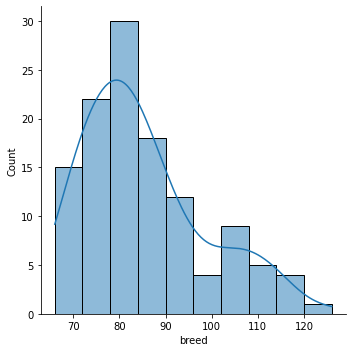

In [18]:
sns.displot(labels["breed"].value_counts(), kde=True);

It seems the breeds are fairly evenly distributed between 66-126 images each, having at least 66 photos of each breed. My main concerns here were having too little data for a particular class, or having extremely imbalanced amounts of data between classes. While the distribution isn't perfect, it doesn't look like either should be of concern here!

---

#### Converting labels to use-able format

In order to use the labels in our model, we need them in a format that will work within our plans. The model will ultimately output a value of 0-1 for each of the 120 breeds, the maximum of which will be its "guess" for the breed. To fit this framework, we need to one hot encode the true labels to match this output.

In [19]:
label_names = labels["breed"].to_numpy()
label_names[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [20]:
unique_breeds = np.unique(label_names)

In [21]:
one_hot_labels = [label == np.array(unique_breeds) for label in label_names]

In [23]:
one_hot_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Now we have a label for each entry that is a one hot encoded array of every class. It shows True for the true label and False for the other 119!

---

#### Checking out my favorite breeds

Next up, let's work with the images in the training set. My partner and I have recently talked about getting a puppy. We have a few breeds we have talked about, so I though it would be fun to look at the pictures on hand of some of them! As a bonus, it's a good way to practice displaying some images

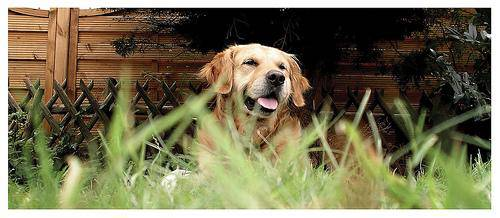

In [24]:
goldens = labels.loc[labels["breed"]=="golden_retriever"].reset_index()
golden_pic = train_path + str(goldens["id"][15]) + ".jpg"
Image(golden_pic)

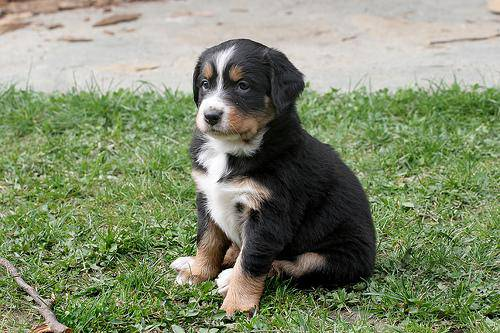

In [25]:
berners = labels.loc[labels["breed"]=="bernese_mountain_dog"].reset_index()
berner = train_path + str(berners["id"][1]) + ".jpg"
Image(berner)

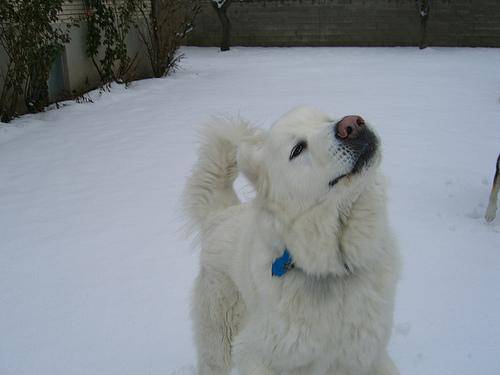

In [26]:
pyrs = labels.loc[labels["breed"]=="great_pyrenees"].reset_index()
pyr = train_path + str(pyrs["id"][49]) + ".jpg"
Image(pyr)

We had some fun flipping through the pictures of our favorite breeds, and it also helped me devise a method for grabbing and displaying a picture! Now to do it for all the images

---

#### Getting image filenames

As we did above, we can grab the filename from id column of the labels .csv file and turn that into a list of filenames for every image in the training dataset. That will allow us to grab any image and apply manipulations, like turning it into a Tensor for our model, or just plain display it!

In [28]:
img_filenames = [train_path + filename + ".jpg" for filename in labels["id"]]

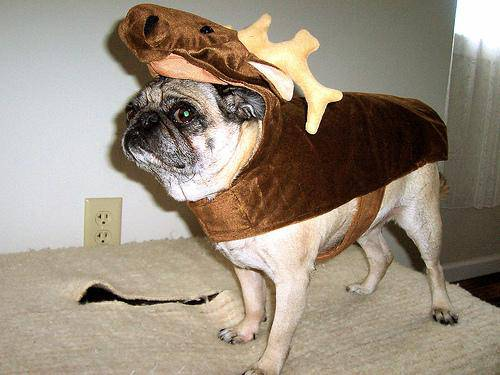

In [29]:
# Display a random image 

Image(img_filenames[9811])

Wow, the rare Pug/Moose hybrid. A Mug?

Anyway, with our images as features and our one-hot encoded labels, we are ready to get started on the Deep Learning portion of the project

In [59]:
X = img_filenames
y = one_hot_labels

# Confirm our sets match in length
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")

Number of images: 10222
Number of labels: 10222


### Transfer Learning 



#### Define parameters

Defining the configurations to be used for our model.

In [60]:
# Model to be used for transfer learning
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

# Image size prescribed by the selected transfer learning model
img_size = 224

# Input shape dictated by the model 
input_shape = [None, img_size, img_size, 3]

# Output shape dictated by our classes
output_shape = len(unique_breeds)

# Number of epochs to train
num_epochs = 100

# Dynamically tune fetching of data
autotune = tf.data.AUTOTUNE

#### Utility Functions

In order to enable batch processing, as well as ease of use to run through training and testing a few times over, we're going to need some utility functions. First we'll need to take an image and process it into a tensor that meets our input parameters

In [61]:
def preprocess_img(img_path):
    """
    Pre-processing steps for image data. Read in image, decode into a tensor,
    Scale color channels to 0-1 scale, and resize to desired input size. Return
    the processed image.
    """
    # Read in image
    img = tf.io.read_file(img_path)
    
    # Convert image to tensor with three color channels
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Scale color channels to 0-1 scale from 0-255 RGB values
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize image to 224x224
    img = tf.image.resize(img, size=[img_size, img_size])
    
    return img 

We could have included the label in our return for the pre-processing function, but this approach decouples the two so that our function is useable for both train and test sets.

In [62]:
def get_img_label(img_path, label):
    """
    Process image using pre-processing steps and return the image with its label
    """
    img = preprocess_img(img_path)
    
    return img, label

In [132]:
def augment(img_path, label, seed):
    image, label = get_img_label(img_path, label)                    
    image = tf.image.resize_with_crop_or_pad(image, img_size + 6, img_size + 6)
    
    # Make a new seed.
    new_seeds = tf.random.experimental.stateless_split(seed, num=2)
    brightness, flip = new_seeds[0, :], new_seeds[1, :]
                                 
    # Random crop back to the original size
    image = tf.image.stateless_random_crop(image, size=[img_size, img_size, 3], seed=seed)
                                 
    # Random brightness
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=brightness)
    image = tf.clip_by_value(image, 0, 1)
    
    # Random flip
    image = tf.image.stateless_random_flip_left_right(image, seed=flip)
                                 
    return image, label

In [75]:
# Create a generator.
rng = tf.random.Generator.from_seed(58, alg='philox')

def wrapper(img_path, label):
    seed = rng.make_seeds(2)[0]
    image, label = augment(img_path, label, seed)
    return image, label

In [141]:
def create_batches(x, y=None, batch_size=32, validation=False, test=False):
    """
    Process image data into batches from image and label pairs (x, y respectively). 
    Uses shuffle for training data, no shuffling for validation data, and acceps test
    data without labels. 
    """
    if test:
        print("Building Test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        data_batch = data.map(preprocess_img, num_parallel_calls=autotune).batch(batch_size)
        data_batch = data_batch.prefetch(autotune)
        return data_batch
    
    elif validation:
        print("Building Validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_img_label, num_parallel_calls=autotune).batch(batch_size)
        data_batch = data_batch.prefetch(autotune)
        return data_batch
    
    else:
        print("Building Training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data = data.map(wrapper, num_parallel_calls=autotune)
        data_batch = data.batch(batch_size)
        data_batch = data_batch.prefetch(autotune)
        return data_batch

In [77]:
def show_batch(images, labels):
    """
    Display images titled with their correct labels for a batch of data 
    """
    plt.figure(figsize=(15, 15))
    for i in range(32):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

In [ ]:
def create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url):
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    
    model.build(input_shape)
    
    return model

In [143]:
def create_tensorboard_callback():
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [144]:
def create_early_stopping_callback():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [145]:
def train_model():
    model = create_model()
    
    tensorboard = create_tensorboard_callback()
    early_stopping = create_early_stopping_callback()
    
    model.fit(x=train_data,
             epochs=num_epochs,
             validation_data=validation_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])
    
    return model

In [146]:
def save_model(model, suffix=None):
    modeldir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + "-" + suffix + ".h5"
    model.save(model_path)
    
    return model_path

In [147]:
def load_model(model_path):
    model = tf.kera.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})
    
    return model

In [148]:
def get_prediction_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

In [149]:
def unbatch_data(data):
    """
    """
    imgs = []
    labels = []
    
    for img, label in data.unbatch().as_numpy_iterator():
        imgs.append(img)
        labels.append(unique_breeds[np.argmax(label)])
    
    return imgs, labels

In [150]:
def plot_prediction(prediction_probabilities, labels, imgs, n=1):
    """
    """
    pred_prob, true_label, img = prediction_probabilities[n], labels[n], imgs[n]
    
    predicted_label = get_prediction_label(pred_prob)
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"
    
    plt.title("{} {:2.0f} ({})".format(predicted_label, np.max(pred_prob)*100, true_label), color=color)

In [151]:
def plot_prediction_confidence(prediction_probabilities, labels, n=1):
    """
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]
    
    pred_label = get_prediction_label(pred_prob)
    
    top_prediction_indices = pred_prob.argsort()[-5:][::-1]
    top_prediction_values = pred_prob[top_prediction_indices]
    top_prediction_labels = unique_breeds[top_prediction_indices]
    
    top_plot = plt.barh(np.arange(len(top_prediction_labels)), top_prediction_values, color="grey")
    plt.yticks(np.arange(len(top_prediction_labels)), labels=top_prediction_labels)
    
    if np.isin(true_label, top_prediction_labels):
        top_plot[np.argmax(top_prediction_labels == true_label)].set_color("green")
    else:
        pass

#### Setting up the model

In [133]:
# Define a subset of the images to use in initial run
subset = 5000

# Split into train and validation sets 

X_train, X_validation, y_train, y_validation = train_test_split(X[:subset],
                                                                y[:subset], 
                                                                test_size=0.2, 
                                                                random_state=23)

In [134]:
train_data = create_batches(X_train, y_train)
validation_data = create_batches(X_validation, y_validation, validation=True)

Building Training data batches...
Building Validation data batches...


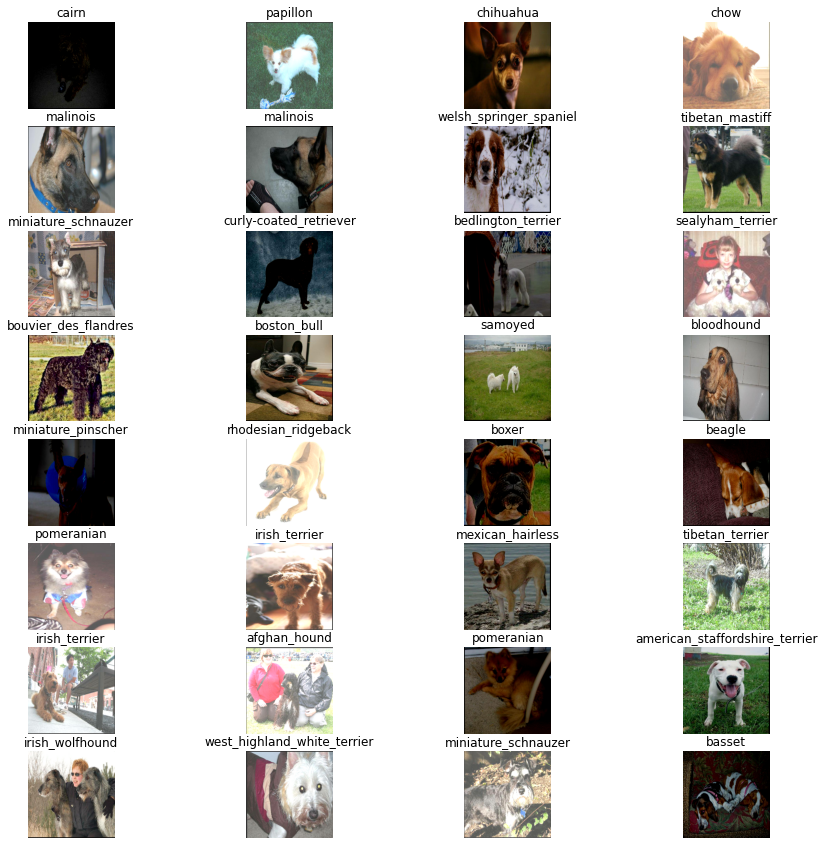

In [136]:
train_imgs, train_labels = next(train_data.as_numpy_iterator())
show_batch(train_imgs, train_labels)

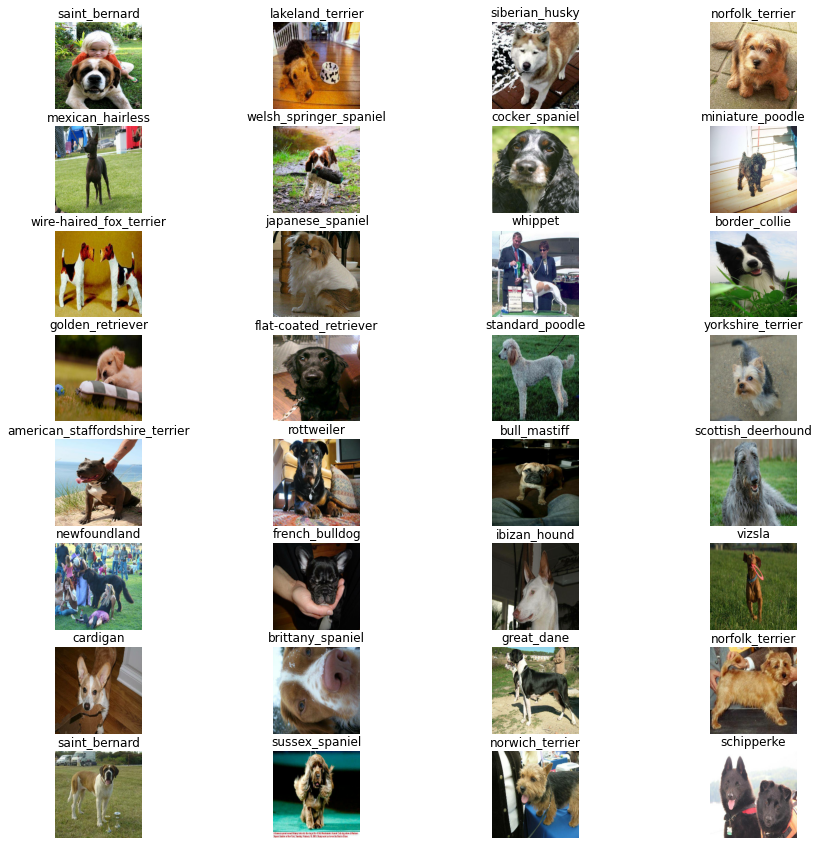

In [82]:
validation_imgs, validation_labels = next(validation_data.as_numpy_iterator())
show_batch(validation_imgs, validation_labels)

In [84]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [90]:
model = train_model()

Epoch 1/100
125/125 [==============================] - 97s 746ms/step - loss: 2.5621 - accuracy: 0.4342 - val_loss: 1.0099 - val_accuracy: 0.7170
Epoch 2/100
125/125 [==============================] - 94s 751ms/step - loss: 0.8135 - accuracy: 0.7795 - val_loss: 0.8047 - val_accuracy: 0.7710
Epoch 3/100
125/125 [==============================] - 92s 737ms/step - loss: 0.5827 - accuracy: 0.8420 - val_loss: 0.7780 - val_accuracy: 0.7670
Epoch 4/100
125/125 [==============================] - 94s 751ms/step - loss: 0.4692 - accuracy: 0.8758 - val_loss: 0.7608 - val_accuracy: 0.7640
Epoch 5/100
125/125 [==============================] - 97s 776ms/step - loss: 0.3800 - accuracy: 0.8988 - val_loss: 0.7408 - val_accuracy: 0.7840
Epoch 6/100
125/125 [==============================] - 93s 741ms/step - loss: 0.3360 - accuracy: 0.9110 - val_loss: 0.7652 - val_accuracy: 0.7730
Epoch 7/100
125/125 [==============================] - 94s 750ms/step - loss: 0.2786 - accuracy: 0.9247 - val_loss: 0.7661 -

In [91]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3199), started 2 days, 8:23:11 ago. (Use '!kill 3199' to kill it.)

In [92]:
predictions = model.predict(validation_data, verbose=1)
predictions.shape

32/32 [==============================] - 19s 589ms/step


(1000, 120)

In [95]:
validation_imgs, validation_labels = unbatch_data(validation_data)

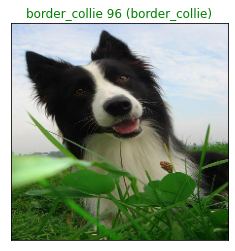

In [129]:
plot_prediction(prediction_probabilities=predictions,imgs=validation_imgs, labels=validation_labels, n=11)

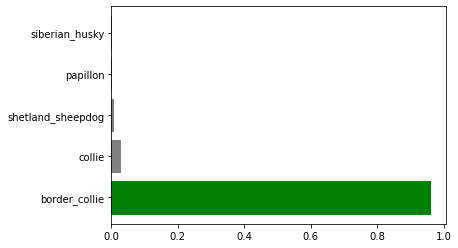

In [130]:
plot_prediction_confidence(prediction_probabilities=predictions, labels=validation_labels, n=11)

In [109]:
half_with_augmentation = save_model(model, suffix="5000-imgs-Augmentation-Adam")

#### Training on full dataset

In [110]:
# Split into train and validation sets 

X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y, 
                                                                test_size=0.2, 
                                                                random_state=23)

In [111]:
train_data = create_batches(X_train, y_train)
validation_data = create_batches(X_validation, y_validation, validation=True)

Building Training data batches...
Building Validation data batches...


In [166]:
full_data = create_batches(X, y)

Building Training data batches...


In [167]:
full_model_no_val = create_model()

In [170]:
full_model_no_val_tensorboard = create_tensorboard_callback()
full_model_no_val_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [171]:
full_model_no_val.fit(x=full_data, 
               epochs=num_epochs, 
               callbacks=[full_model_no_val_tensorboard, full_model_no_val_early_stopping]
              )

Epoch 1/100
320/320 [==============================] - 244s 751ms/step - loss: 1.6683 - accuracy: 0.5915
Epoch 2/100
320/320 [==============================] - 245s 767ms/step - loss: 0.7668 - accuracy: 0.7748
Epoch 3/100
320/320 [==============================] - 235s 734ms/step - loss: 0.6309 - accuracy: 0.8143
Epoch 4/100
320/320 [==============================] - 239s 746ms/step - loss: 0.5487 - accuracy: 0.8349
Epoch 5/100
320/320 [==============================] - 240s 750ms/step - loss: 0.5064 - accuracy: 0.8453
Epoch 6/100
320/320 [==============================] - 249s 779ms/step - loss: 0.4649 - accuracy: 0.8601
Epoch 7/100
320/320 [==============================] - 237s 741ms/step - loss: 0.4409 - accuracy: 0.8671
Epoch 8/100
320/320 [==============================] - 236s 737ms/step - loss: 0.4245 - accuracy: 0.8770
Epoch 9/100
320/320 [==============================] - 235s 734ms/step - loss: 0.3986 - accuracy: 0.8860
Epoch 10/100
320/320 [==============================] -

In [172]:
full_with_augment_no_val = save_model(full_model_no_val, suffix="Full-Augmentation-Adam-NoVal")

#### Predictions on Test Data

In [152]:
test_filenames = [test_path + filename for filename in os.listdir(test_path)]
len(test_filenames)

10357

In [153]:
test_data = create_batches(test_filenames, test=True)

Building Test data batches...


In [173]:
test_predictions = full_model_no_val.predict(test_data, verbose=1)

324/324 [==============================] - 239s 736ms/step


In [174]:
predictions_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
predictions_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
predictions_df[list(unique_breeds)] = test_predictions

predictions_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3d709301162cd8930b62281ef8ac09dc,1.083167e-09,2.407300e-08,2.693959e-10,3.373314e-10,1.899580e-10,3.989625e-07,9.445323e-08,1.614604e-05,7.489614e-12,...,9.536810e-09,2.381457e-05,2.201380e-10,4.625592e-09,1.784066e-13,3.176314e-09,1.256729e-07,9.029924e-09,1.417682e-09,5.201784e-07
1,bc3996f9194cbf029eea8b8936805ee9,1.044191e-06,6.227372e-09,7.419282e-11,8.792895e-09,4.205770e-07,5.097368e-10,4.180277e-09,3.517418e-07,2.746516e-10,...,1.966855e-08,2.221650e-07,4.972902e-09,7.410454e-06,6.288528e-10,2.624440e-10,2.242660e-09,2.634926e-06,1.371744e-04,5.406534e-09
2,6299acc64fb0e2034a8615d77aa49e91,1.147837e-09,1.119963e-07,5.818374e-11,2.849605e-11,6.120390e-09,2.479916e-07,2.630019e-05,1.195992e-07,1.238077e-09,...,1.159665e-10,4.397920e-04,1.765011e-08,7.560650e-11,9.464150e-15,2.740283e-10,1.411036e-08,1.116057e-08,2.614648e-09,1.487475e-07
3,b27db8a2a89901a034ec4b2050a9acca,3.280335e-11,2.895385e-09,2.408629e-08,2.599147e-07,1.873986e-08,5.789694e-08,7.720957e-08,1.129731e-06,5.063204e-10,...,1.459441e-10,3.091961e-07,4.565742e-10,1.140237e-08,9.884521e-09,7.042190e-10,1.389437e-10,2.294427e-08,1.357464e-07,4.867759e-10
4,09d8b8ff0e64f4e8f908827efdd114ae,5.742894e-03,2.373262e-09,1.769003e-06,7.473269e-11,3.255198e-07,5.838904e-10,1.224928e-02,2.470949e-09,3.928934e-09,...,1.151807e-06,6.486185e-02,9.346520e-10,3.337832e-11,1.324961e-07,1.012640e-07,4.506684e-04,1.290106e-09,5.240167e-03,7.162978e-01


In [175]:
predictions_df.to_csv("sub_mobilenet_augmentation_noval.csv", index=False)

In [211]:
friends_path = filepath + "dogs/"
friends_image_paths = [friends_path + filename for filename in os.listdir(friends_path)]

In [212]:
friends_data = create_batches(friends_image_paths, test=True)

Building Test data batches...


In [213]:
friends_predictions = full_model_no_val.predict(friends_data)

In [214]:
friends_predicted_labels = [get_prediction_label(friends_predictions[i]) for i in range(len(friends_predictions))]

In [215]:
friends_images =[]
for image in friends_data.unbatch().as_numpy_iterator():
    friends_images.append(image)

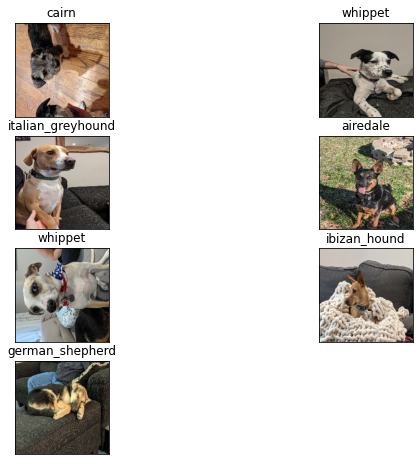

In [217]:
plt.figure(figsize=(10,10))
for i, image in enumerate(friends_images):
    plt.subplot(5, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(friends_predicted_labels[i])
    plt.imshow(image)

In [218]:
gracie_path = filepath + "gracie/"
gracie_image_paths = [gracie_path + filename for filename in os.listdir(gracie_path)]

In [219]:
gracie_data = create_batches(gracie_image_paths, test=True)

Building Test data batches...


In [220]:
gracie_predictions = full_model_no_val.predict(gracie_data)

In [224]:
gracie_predicted_labels = [get_prediction_label(gracie_predictions[i]) for i in range(len(gracie_predictions))]

In [225]:
gracie_images =[]
for image in gracie_data.unbatch().as_numpy_iterator():
    gracie_images.append(image)

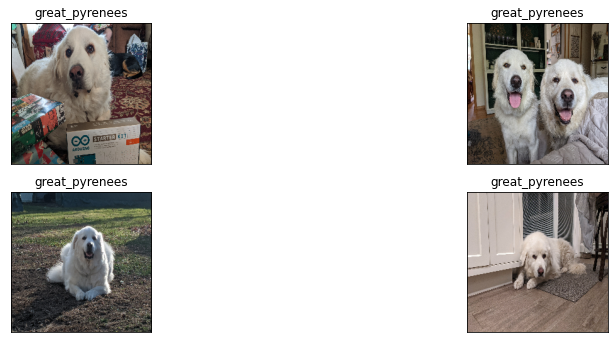

In [226]:
plt.figure(figsize=(15,15))
for i, image in enumerate(gracie_images):
    plt.subplot(5, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(gracie_predicted_labels[i])
    plt.imshow(image)